### CHALLENGE_03

Linear Model: Fit a regression model (with an out-of-sample R42 of > 0.01) to a financial time series.
    
Financial series have a low signal-to-noise ratio, so even a weak correlation will require some basic feature engineering (moving average prices, volatility, etc).
    
What are some of the weaknesses of the model an how can it be improved with additional work?

In [1]:
# Import Modules
import numpy as np
import pandas as pd
import warnings
import itertools
import statsmodels.api as sm
import matplotlib.pyplot as plt

In [2]:
# Ignore warnings
warnings.filterwarnings("ignore")

plt.style.use("ggplot")

In [3]:
# Load Dataset
df = pd.read_csv("data/NSE_20.csv", parse_dates=["Date"], index_col=0).sort_index(ascending=True)
df.sample(2)

,Index
Date,
2008-12-10,3205.91
2001-08-28,1519.21


In [4]:
# Size of Dataset
df.shape

(4225, 1)

In [5]:
# Check Date Range
str(df.index.min()), str(df.index.max())

('2001-01-04 00:00:00', '2017-12-29 00:00:00')

In [6]:
# Check Datatypes
df.dtypes

 Index     float64
dtype: object

In [7]:
# Check Missing Values
df.isna().sum()

 Index     0
dtype: int64

In [8]:
# Resample Time Series to Weekly Frequencies
df_resampled = df.resample("W").mean()
df_resampled.dropna(inplace=True)
df_resampled.sample(2)

,Index
Date,
2010-02-28,3609.900
2012-10-28,4094.792


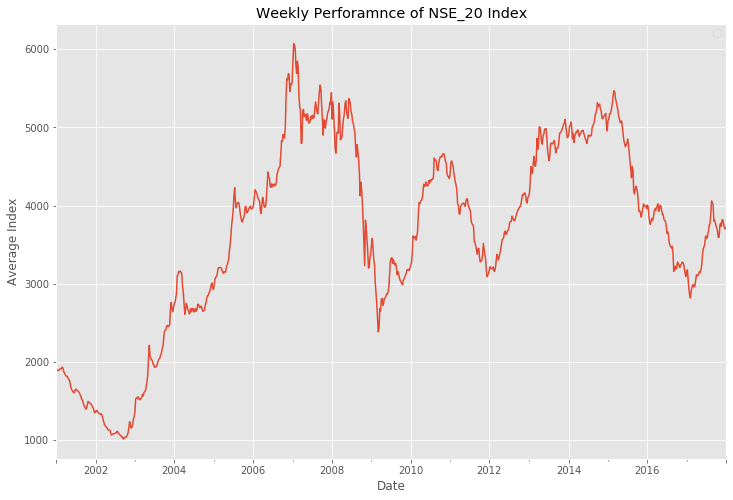

In [9]:
# Weekly Perforamnce of NSE_20 Index
fig, ax = plt.subplots(figsize=(12, 8))
df_resampled.plot(kind="line", ax=ax)
plt.legend("")
ax.set_xlabel("Date")
ax.set_ylabel("Average Index")
ax.set_title("Weekly Perforamnce of NSE_20 Index")
plt.savefig("images/Weekly_Perforamnce_of_NSE_20_Index.svg")

In [10]:
# Check Missing Values
df_resampled.isna().sum()

 Index     0
dtype: int64

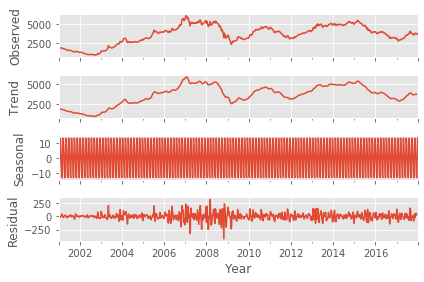

In [11]:
# Time Series Decomposition
decomp = sm.tsa.seasonal_decompose(df_resampled, model="additive", freq=7)
fig = decomp.plot()
plt.xlabel('Year')
plt.savefig('images/Time_Series_Decomposition.svg')

In [12]:
# Check Dimension
df_resampled.shape

(887, 1)

In [13]:
# Train/Test Split Parameters
n = df_resampled.shape[0]
test_size = int(0.01 * n)

In [14]:
# Train/Test Split
train = df_resampled[:-test_size]
test = df_resampled[-test_size:]
train.shape[0], test.shape[0]

(879, 8)

In [15]:
# Time series forecasting with ARIMA
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in pdq]

print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [ ]:
# Hyperparameter Optimization
minimum = {"param": "", "param_seasonal": "", "results":15000}
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(train, order=param, seasonal_order=param_seasonal, enforce_stationarity=False, enforce_invertibility=False)
            results = mod.fit()
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
            
            if results.aic < minimum["results"]:
                minimum["param"] = param
                minimum["param_seasonal"] = param_seasonal
                minimum["results"] = results.aic
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:16986.972238624312
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:16159.613113239571
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:12750.55186957607
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:12541.718870950786
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:12766.318768995077
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:12714.242910354737
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:12548.7403225468
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:12535.045402237818
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:16319.794348535006
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:14494.146995369221
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:11776.233047898257
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:11596.203410371461
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:11797.54391738222


In [ ]:
# Model Fitting
mod = sm.tsa.statespace.SARIMAX(train, order=minimum["param"], seasonal_order=minimum["param_seasonal"], enforce_stationarity=False, enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

In [ ]:
# Run Diagnostics
fig = results.plot_diagnostics(figsize=(16, 12))
plt.savefig('images/Model_Diagnostics_Cumulative.png')

In [ ]:
# Model Validating
pred = results.get_prediction(start=pd.to_datetime('2016-01-03'), dynamic=False)
pred_ci = pred.conf_int()

ax = train['2000':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(16, 12))
ax.fill_between(pred_ci.index, pred_ci.iloc[:, 0], pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Year')
ax.set_ylabel('Weighted Average Rate')
ax.set_title('Model Validation')
ax.legend()
plt.savefig("images/Model_Validation.png")

In [ ]:
# Error
validation_forecasted = pred.predicted_mean.to_frame("predictions")
validation_truth = train['2016-01-03':]
mse = ((validation_forecasted["predictions"] - validation_truth[" Index "]) ** 2).mean()

print('The Mean Squared Error of our validation set is {}'.format(round(mse, 2)))
print('The Root Mean Squared Error of our validation set is {}'.format(round(np.sqrt(mse), 2)))

In [ ]:
# Model Pridiction
pred_uc = results.get_forecast(steps=8)
pred_ci = pred_uc.conf_int()

ax = train.plot(label='observed', figsize=(16, 12))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index, pred_ci.iloc[:, 0], pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Year')
ax.set_ylabel('Customer Count')
ax.set_title('Customer Opened Forecast')
ax.legend()
plt.savefig('images/Model_prediction.png')

In [ ]:
# Error
test_forecasted = pred_uc.predicted_mean.to_frame("predictions")
test_truth = test
mse = ((test_forecasted["predictions"] - test_truth[" Index "]) ** 2).mean()

print('The Mean Squared Error of our test set is {}'.format(round(mse, 2)))
print('The Root Mean Squared Error of our test set is {}'.format(round(np.sqrt(mse), 2)))